In [541]:
#### import library ####
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import isclose

In [542]:
#### Experimental Setup ####
p = 7 #[mTorr] Pressure
kB = 1.38e-23 #[J/K] [m2 kg K-1 s-2] Boltzmann constant
kB1 = 8.617e-5 #[eV/K] Boltzmann constant
e = 1.6e-19 #[C] electronic charge
M = 1.67e-27 #[kg] mass of H atom
m = 9.1e-31 #[kg] mass of electorn
ro = 2.75 #[cm] radius of chamber
l = 24 #[cm] chamber length 
Tg = 300 #[K] room temperature
V = np.pi*ro**2*l #[cm^3] discharge volume
A = 2*np.pi*ro*l+2*np.pi*ro**2 #[cm^2] loss area
v0 = 100*(8*Tg*kB/(M*np.pi))**0.5 #[cm/s] mean velocity of H atom
ng = (p/7.5)/(Tg*kB)*1e-6 #[cm^-3]
sigma_i = 5e-15 #[cm2] #
lambda_i = 1/(ng*sigma_i) #[cm] ion-neutral mean free path
hl = 0.86*(3+l/2/lambda_i)**-0.5
hR = 0.8*(4+ro/lambda_i)**-0.5
Aeff = 2*np.pi*ro*(l*hR+ro*hl)  #[cm^2] effective area
deff = V/Aeff #[cm]
g = 0.1 #Recombination Factor
LAMBDAeff = ((2.405/ro)**2+(np.pi/l)**2)**-0.5 #[cm]
D_Kn = v0 * LAMBDAeff/3 #[cm2/s]
Deff = D_Kn
T1 = LAMBDAeff**2/Deff #[s]

In [643]:
###### Functions ######
def electron_balance_eqn(x, t, Power): 
    Te = x[0]
    nH = x[1]
    nHp = x[2]
    nH2p = x[3]
    nH3p = x[4]
    uB = np.sqrt(kB/kB1*Te/M)*100 #[cm/s] #kB/kB1 = e
    Vs = Te*np.log(np.sqrt(M/(2*np.pi*m)))
    t0 = V/Aeff*np.sqrt(M/(kB/kB1*Te))/100 #[s] Characteristic transit time of H+ ion 
    
    ##### Rate coefficient calculation #####
    # ref. R. K. Janev, et al., Elementary Processes in Hydrogen-Helium Plasmas, Springer (1987)
    # H + e -> H+ + 2e, Reaction 2.1.5 E = 13.6
    k1 = np.exp(-3.271396786375e+01+1.353655609057e+01*np.log(Te)-5.739328757388e+00*(np.log(Te))**2+1.563154982022e+00*(np.log(Te))**3-2.877056004391e-01*(np.log(Te))**4+3.482559773737e-02*(np.log(Te))**5-2.631976175590e-03*(np.log(Te))**6+1.119543953861e-04*(np.log(Te))**7-2.039149852002e-06*(np.log(Te))**8)
    # H+ + e -> H + hv, Reaction 2.1.8 E = Te
    k2 = 3.92e-14*(13.6/Te)**1.5/(13.6/Te+0.35) # n = 1s
    # H2 + e -> 2H + e, Reaction 2.2.5 E = 10
    k3 = np.exp(-2.858072836568e+01+1.038543976082e+01*np.log(Te)-5.383825026583e+00*(np.log(Te))**2+1.950636494405e+00*(np.log(Te))**3-5.393666392407e-01*(np.log(Te))**4+1.006916814453e-01*(np.log(Te))**5-1.160758573972e-02*(np.log(Te))**6+7.411623859122e-04*(np.log(Te))**7-2.001369618807e-05*(np.log(Te))**8)
    # H2 + e -> H2+ + 2e, Reaction 2.2.9 E = 15.4
    k4 = np.exp(-3.568640293666e+01+1.733468989961e+01*np.log(Te)-7.767469363538e+00*(np.log(Te))**2+2.211579405415e+00*(np.log(Te))**3-4.169840174384e-01*(np.log(Te))**4+5.088289820867e-02*(np.log(Te))**5-3.832737518325e-03*(np.log(Te))**6+1.612863120371e-04*(np.log(Te))**7-2.893391904431e-06*(np.log(Te))**8)
    # H2 + e -> H+ + H + 2e, Reaction 2.2.10 E = 18
    k5 = np.exp(-3.834597006782e+01+1.426322356722e+01*np.log(Te)-5.826468569506e+00*(np.log(Te))**2+1.727940947913e+00*(np.log(Te))**3-3.598120866343e-01*(np.log(Te))**4+4.822199350494e-02*(np.log(Te))**5-3.909402993006e-03*(np.log(Te))**6+1.738776657690e-04*(np.log(Te))**7-3.252844486351e-06*(np.log(Te))**8)
    # H2+ + e -> 2H+ + 2e, Reaction 2.2.11 E = 15.5
    k6 = np.exp(-3.746192301092e+01+1.559355031108e+01*np.log(Te)-6.693238367093e+00*(np.log(Te))**2+1.981700292134e+00*(np.log(Te))**3-4.044820889297e-01*(np.log(Te))**4+5.352391623039e-02*(np.log(Te))**5-4.317451841436e-03*(np.log(Te))**6+1.918499873454e-04*(np.log(Te))**7-3.591779705419e-06*(np.log(Te))**8)
    # H2+ + e -> H+ + H + e, Reaction 2.2.12 E = 10.5
    k7 = np.exp(-1.781416067709e+01+2.277799785711e+00*np.log(Te)-1.266868411626e+00*(np.log(Te))**2+4.296170447419e-01*(np.log(Te))**3-9.609908013189e-02*(np.log(Te))**4+1.387958040699e-02*(np.log(Te))**5-1.231349039470e-03*(np.log(Te))**6+6.042383126281e-05*(np.log(Te))**7-1.247521040900e-06*(np.log(Te))**8)
    # H2+ + e -> 2H, Reaction 2.2.14 E = Te
    k8 = np.exp(-1.670435653561e+01-6.035644995682e-01*np.log(Te)-1.942745783445e-08*(np.log(Te))**2-2.005952284492e-07*(np.log(Te))**3+2.962996104431e-08*(np.log(Te))**4+2.134293274971e-08*(np.log(Te))**5-6.353973401838e-09*(np.log(Te))**6+6.152557460831e-10*(np.log(Te))**7-2.025361858319e-11*(np.log(Te))**8)
    # H3+ + e -> H2 + H, Reaction 2.2.15 E = Te
    k9 = np.exp(-1.700270758355e+01-4.050073042947e-01*np.log(Te)+1.018733477232e-08*(np.log(Te))**2-1.695586285687e-08*(np.log(Te))**3+1.564311217508e-10*(np.log(Te))**4+1.979725412288e-09*(np.log(Te))**5-4.395545994733e-10*(np.log(Te))**6+3.584926377078e-11*(np.log(Te))**7-1.024189019465e-12*(np.log(Te))**8)
    # H3+ + e -> H+ + 2H + e, Reaction 2.2.16 E = 14
    k10 = np.exp(-3.078408636631e+01+1.509421488513e+01*np.log(Te)-7.349167207324e+00*(np.log(Te))**2+2.320966107642e+00*(np.log(Te))**3-4.818077551719e-01*(np.log(Te))**4+6.389229162737e-02*(np.log(Te))**5-5.161880953089e-03*(np.log(Te))**6+2.303985092606e-04*(np.log(Te))**7-4.344846146197e-06*(np.log(Te))**8)
    # H2+ + H2 -> H3+ + H, Reaction 4.3.3 E = 0
    k11 = 1.2194578959081685e-09 #for 0.025851eV Hydrogen atom
    # H2 + e -> H2+ + e, Reaction 2.2.2 E = 12.1
    k12 = np.exp(-4.293519441750e+02+5.112210939087e+02*np.log(Te)-2.848127939455e+02*(np.log(Te))**2+8.831033879636e+01*(np.log(Te))**3-1.665959177505e+01*(np.log(Te))**4+1.957960915869e+00*(np.log(Te))**5-1.401282416514e-01*(np.log(Te))**6+5.591134833381e-03*(np.log(Te))**7-9.537010324465e-05*(np.log(Te))**8)

    ##### Energy Loss per Reaction #####
    E1 = 13.6
    E2 = Te
    E3 = 10
    E4 = 15.4
    E5 = 18
    E6 = 15.5
    E7 = 10.5
    E8 = Te
    E9 = Te
    E10 = 14
    E11 = 0
    E12 = 12.1

    #Quasi-Neutrality eqn
    ne = nHp + nH2p + nH3p
    
    #Hydrogen atom conservation eqn
    nH2 = ng - (0.5*(nH+nHp)+nH2p+1.5*nH3p)
    
    #Particle balance eqn for electron
    #dne_dt = (k1*ne*nH)+(k4*ne*nH2)+(k5*ne*nH2)+(k6*ne*nH2p)-(k2*ne*nHp)-(k8*ne*nH2p)-(k9*ne*nH3p)-ne*uB*Aeff/V
    dne_dt = (k1*ne*nH)+(k12*ne*nH2)+(k4*ne*nH2)+(k5*ne*nH2)+(k6*ne*nH2p)-(k2*ne*nHp)-(k9*ne*nH3p)-ne*uB*Aeff/V
    
    #Power balance eqn for electron
    dT_dt = 2/(3*ne)*(Power(t)/V - (Vs+5/2*Te)*ne*uB*Aeff/V - 3/2*Te*dne_dt - (k1*nH*E1*ne + k2*nHp*E2*ne + k3*nH2*E3*ne + k4*nH2*E4*ne + k5*nH2*E5*ne + k6*nH2p*E6*ne + k7*nH2p*E7*ne + k8*nH2p*E8*ne + k9*nH3p*E9*ne + k10*nH3p*E10*ne + k11*nH2p*E11*nH2 + k12*nH2*E12*ne))

    #Particle balance eqn for other species except electron
    #dnH_dt = -(k1*ne*nH)+(k2*nHp*ne)+2*(k3*nH2*ne)+(k5*nH2*ne)+(k7*nH2p*ne)+2*(k8*nH2p*ne)+(k9*nH3p*ne)+2*(k10*nH3p*ne)+(k11*nH2p*nH2)-(nH/(T1/g))+(nHp/(t0/x6))+(nH3p/(np.sqrt(3)*t0/x6))
    #dnHp_dt = (k1*ne*nH)-(k2*nHp*ne)+(k5*nH2p*ne)+2*(k6*nH2p*ne)+(k7*nH2p*ne)+(k10*nH3p*ne)-(nHp/(t0/x6))
    #dnH2p_dt = (k4*nH2*ne)-(k6*nH2p*ne)-(k7*nH2p*ne)-(k8*nH2p*ne)-(k11*nH2p*nH2)-(nH2p/(np.sqrt(2)*t0/x6))
    #dnH3p_dt = -(k9*nH3p*ne)-(k10*nH3p*ne)+(k11*nH2p*nH2)-(nH3p/(np.sqrt(3)*t0/x6))
    dnH_dt = -(k1*ne*nH)+(k2*nHp*ne)+2*(k3*nH2*ne)+(k5*nH2*ne)+(k7*nH2p*ne)+2*(k8*nH2p*ne)+(k9*nH3p*ne)+2*(k10*nH3p*ne)+(k11*nH2p*nH2)-(nH*g/T1)+(nHp/(t0))+(nH3p/(np.sqrt(3)*t0))
    dnHp_dt = (k1*ne*nH)-(k2*nHp*ne)+(k5*nH2p*ne)+2*(k6*nH2p*ne)+(k10*nH3p*ne)-(nHp/(t0))
    dnH2p_dt = (k12*nH2*ne)+(k4*nH2*ne)-(k6*nH2p*ne)-(k7*nH2p*ne)-(k8*nH2p*ne)-(nH2p/(np.sqrt(2)*t0))#-(k11*nH2p*nH2)
    dnH3p_dt = -(k9*nH3p*ne)-(k10*nH3p*ne)+(k11*nH2p*nH2)-(nH3p/(np.sqrt(3)*t0))
    #print((k4*nH2*ne),(k6*nH2p*ne),(k7*nH2p*ne),(k8*nH2p*ne),(k11*nH2p*nH2),(nH2p/(np.sqrt(2)*t0)))
    return [dT_dt, dnH_dt, dnHp_dt, dnH2p_dt, dnH3p_dt]

In [644]:
###### Power Setting ######
P = 1000*6.241509e18 #[eV/s] Input Power
duty = 0.5
period = 1e-3
time_resolution = 1e-7
t = np.arange(0, period, time_resolution)

def Power_rectangular(t):
    if t <= duty*period:
        return P
    else:
        return 0
    
def Power_logistic(t):
    t1 = 50  #Point where the power starts to decrease
    t2 = 150 #Point where the power becomes zero
    C = 2
    B = np.exp(-t2/C)
    A = P/(np.exp(-t1/C)-B)
    
    if t <= t1:
        return P
    elif t <= t2 and t > t1:
        return A*(np.exp(-t/C)-B)
    else:
        return 0

In [645]:
###### Electron Temperature & Density Calculation ######
#x0 = [1,1e11, 1e6, 1e10, 1e9] #Te, nH, nHp, nH2p, nH3p [First guessing]
x0 = [1,1e10,1e10,1e10,1e10]
args = (Power_rectangular,)
ans1 = odeint(electron_balance_eqn, x0, t, args, rtol=10**-3, mxstep=10**6)
T = ans1[:,0]
H = ans1[:,1]
Hp = ans1[:,2]
H2p = ans1[:,3]
H3p = ans1[:,4]
ne = Hp + H2p + H3p
H2 = ng-(0.5*(H+Hp)+H2p+1.5*H3p)

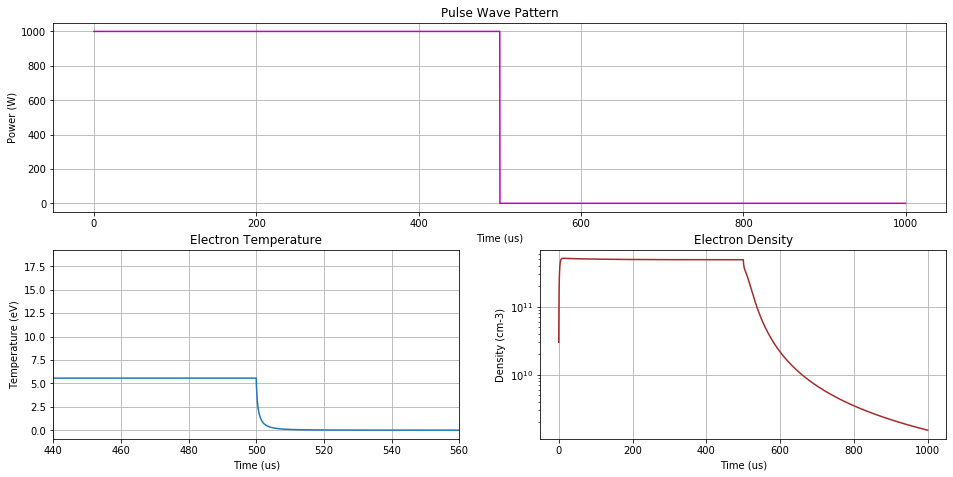

In [646]:
plt.figure(figsize=(16,16))
Power_list = []
for i in t:
    Power_list.append(Power_rectangular(i)/6.241509e18)
    #Power_list.append(Power_rectangular(i))
plt.subplot(411)
plt.plot(t*1e6,Power_list,'m')
plt.title('Pulse Wave Pattern')
plt.xlabel('Time (us)')
plt.ylabel('Power (W)')
plt.grid(True)

plt.subplot(423)
plt.plot(t*1e6,T)
plt.xlabel('Time (us)')
plt.ylabel('Temperature (eV)')
plt.xlim(440,560)
#plt.ylim(0,10)
plt.title('Electron Temperature')
plt.grid(True)

plt.subplot(424)
plt.plot(t*1e6,ne,'brown')
plt.yscale('log')
plt.xlabel('Time (us)')
plt.ylabel('Density (cm-3)')
plt.title('Electron Density')
plt.grid(True)
plt.show()

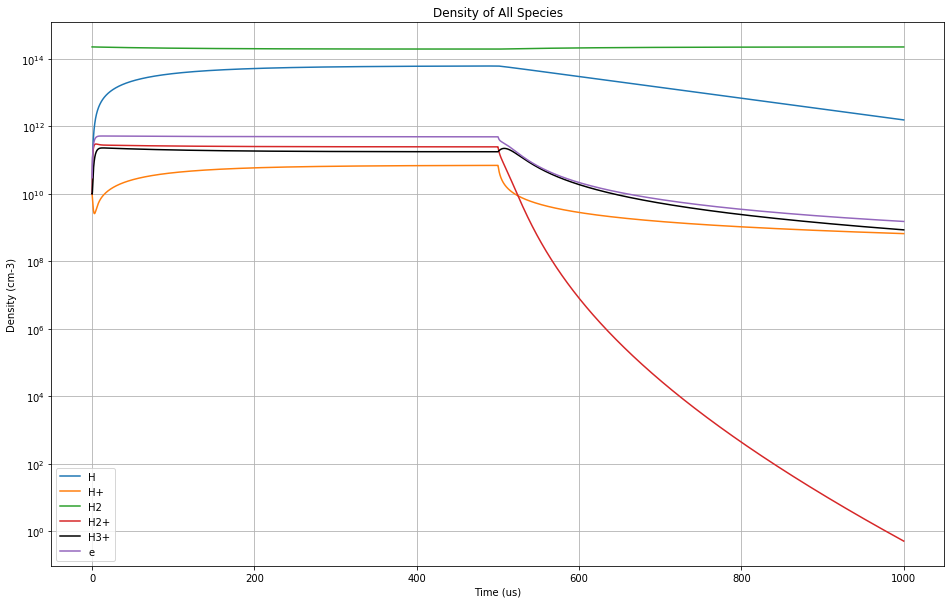

In [647]:
plt.figure(figsize=(16,10))
plt.plot(t*1e6,H,t*1e6,Hp,t*1e6,H2,t*1e6,H2p,t*1e6,H3p,'k',t*1e6,ne)
plt.yscale('log')
plt.xlabel('Time (us)')
plt.ylabel('Density (cm-3)')
#plt.ylim(1e-5,1e18)
plt.legend(['H','H+','H2','H2+','H3+','e'])
plt.title('Density of All Species')
plt.grid(True)
plt.show()

In [648]:
###### Iteration ######
iteration = 0
ne_compare = 1
while((not isclose(ne[-1], ne_compare, rel_tol=1e-5) or (not isclose(H3p[-1], H3p_compare, rel_tol=1e-5)))):
    x0 = [T[-1],H[-1], Hp[-1], H2p[-1], H3p[-1]] #Te, nH, nHp, nH2p, nH3p
    args = (Power_rectangular,)
    ne_compare = ne[-1]
    H3p_compare = H3p[-1]
    ans1 = odeint(electron_balance_eqn, x0, t, args, rtol=10**-2, mxstep=10**3)
    T = np.append(T, ans1[:,0])
    H = np.append(H, ans1[:,1])
    Hp = np.append(Hp, ans1[:,2])
    H2p = np.append(H2p, ans1[:,3])
    H3p = np.append(H3p, ans1[:,4])
    ne_tmp = ans1[:,2] + ans1[:,3] + ans1[:,4]
    H2_tmp = ng - (0.5*(ans1[:,1]+ans1[:,2]) + ans1[:,3] + 1.5*ans1[:,4])
    ne = np.append(ne, ne_tmp)
    H2 = np.append(H2, H2_tmp)
    iteration += 1
    print('iteration count :' + str(iteration))

iteration count :1
iteration count :2
iteration count :3
iteration count :4
iteration count :5
iteration count :6
iteration count :7
iteration count :8
iteration count :9
iteration count :10
iteration count :11
iteration count :12
iteration count :13
iteration count :14
iteration count :15
iteration count :16
iteration count :17
iteration count :18
iteration count :19
iteration count :20
iteration count :21
iteration count :22
iteration count :23
iteration count :24


In [649]:
t_long = np.linspace(0, (iteration+1)*period-time_resolution, (iteration+1)*int(period/time_resolution))
len(t_long)

250000

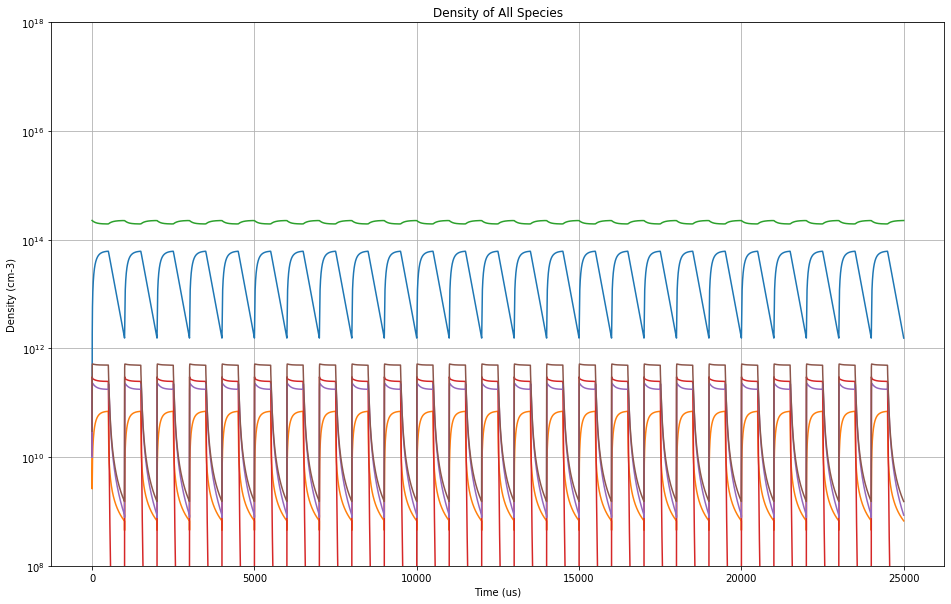

In [651]:
plt.figure(figsize=(16,10))
plt.plot(t_long*1e6,H,t_long*1e6,Hp,t_long*1e6,H2,t_long*1e6,H2p,t_long*1e6,H3p,t_long*1e6,ne)
plt.yscale('log')
plt.xlabel('Time (us)')
plt.ylabel('Density (cm-3)')
plt.ylim(1e8,1e18)
#plt.legend(['H','H+','H2','H2+','H3+','e'])
plt.title('Density of All Species')
plt.grid(True)
plt.show()

In [652]:
data = np.vstack([t_long*1e6,H,Hp,H2,H2p,H3p,ne]).T
data = pd.DataFrame(data)
data.columns= ['Time','H','H+','H2','H2+','H3+','ne']
#data.to_csv('Result.csv')

In [653]:
idx = []
for i in range(iteration+1):
    idx.append(10000*(i+1)-1)

In [654]:
data.iloc[idx]

,Time,H,H+,H2,H2+,H3+,ne
9999,999.9,1.548250e+12,6.631686e+08,2.246671e+14,0.516021,8.575369e+08,1.520705e+09
19999,1999.9,1.545998e+12,6.700981e+08,2.246682e+14,0.426414,8.540137e+08,1.524112e+09
29999,2999.9,1.546009e+12,6.699049e+08,2.246682e+14,0.424552,8.542036e+08,1.524109e+09
39999,3999.9,1.545996e+12,6.693125e+08,2.246682e+14,0.427236,8.546789e+08,1.523991e+09
49999,4999.9,1.546012e+12,6.698401e+08,2.246682e+14,0.424931,8.542784e+08,1.524119e+09
59999,5999.9,1.546022e+12,6.693220e+08,2.246682e+14,0.427332,8.546824e+08,1.524004e+09
69999,6999.9,1.545986e+12,6.699601e+08,2.246682e+14,0.427251,8.541349e+08,1.524095e+09
79999,7999.9,1.545981e+12,6.680628e+08,2.246682e+14,0.431990,8.551907e+08,1.523253e+09
89999,8999.9,1.546012e+12,6.699081e+08,2.246682e+14,0.424541,8.542002e+08,1.524108e+09
99999,9999.9,1.545962e+12,6.693087e+08,2.246682e+14,0.427197,8.546684e+08,1.523977e+09
